In [1]:
import itertools
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression as MI
from scipy import stats as st

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

np.random.seed(666)

# 1. Joint exponentials

----------------------------------------------------------------------------------------------------
Mixing matrix H:
[[ 0.5 -0.5]
 [ 0.5  0.5]]
det(H)=0.5
----------------------------------------------------------------------------------------------------


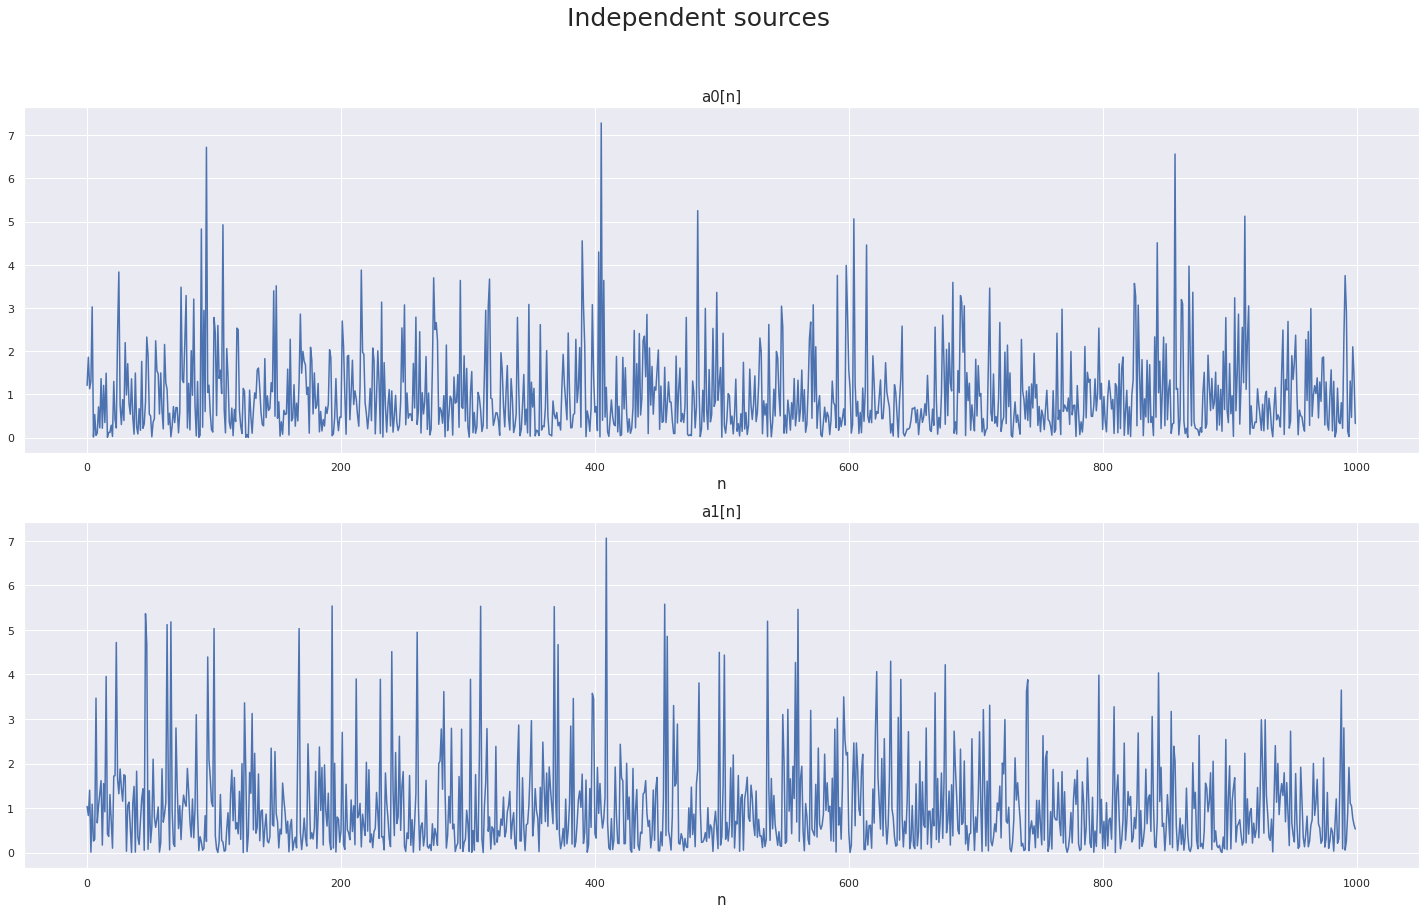

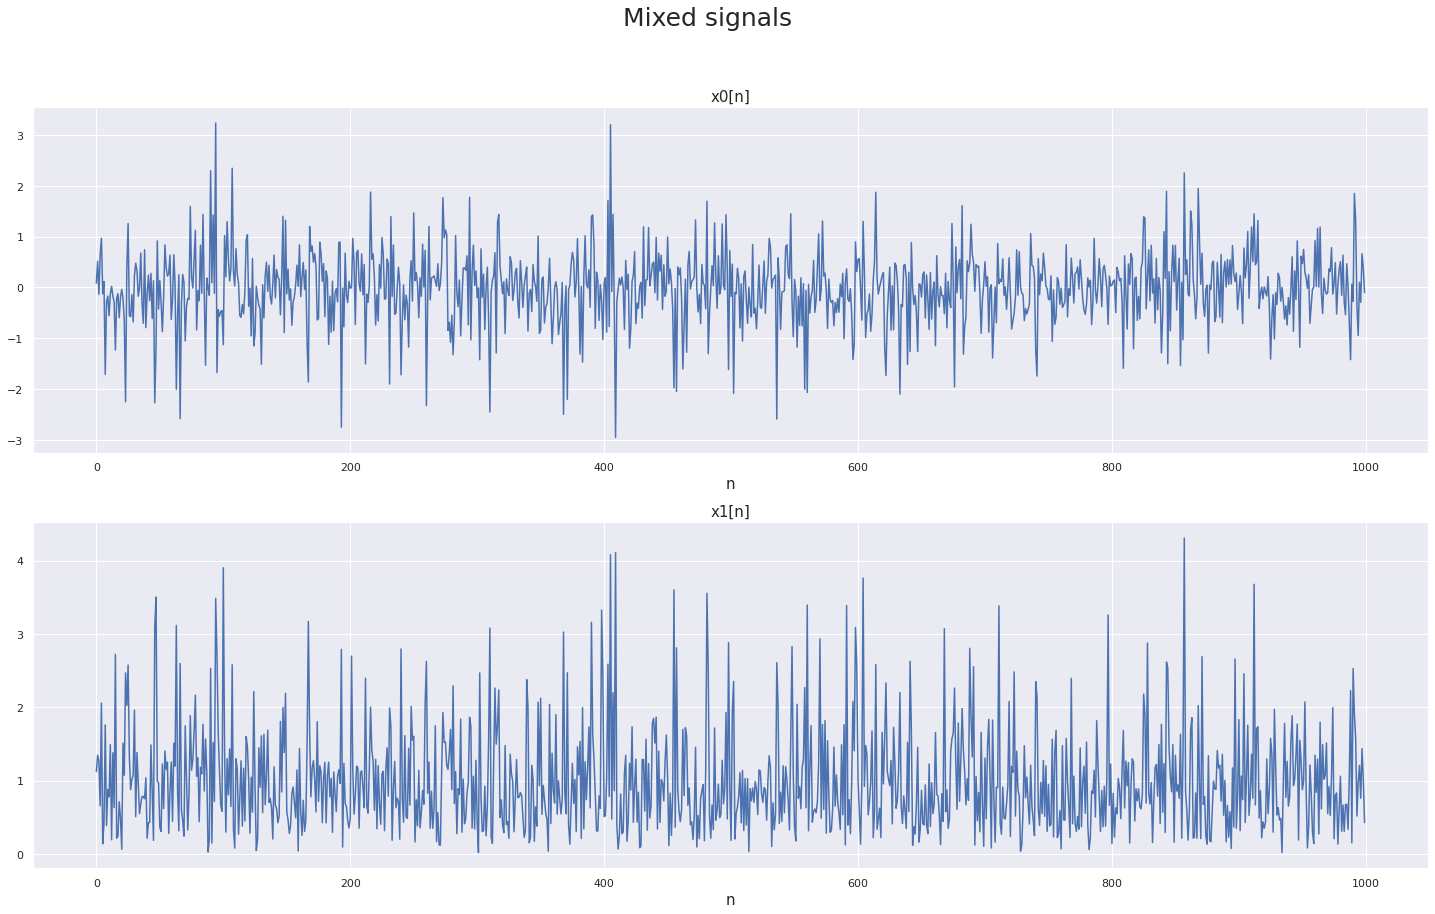

In [2]:
# Signal size
N=1000

# Number of independent sources
K=2

# Individual exponential rates
Lamb = np.array([
    1 for k in range(K)
])

# Generate sources
a = np.empty(
    shape=(K,N)
)
for k in range(K):
    a[k,:] = np.random.exponential(
        scale=1/Lamb[k],
        size=N
    )

# Mixing matrix
# H = np.random.uniform(
#     0,
#     5,
#     size=(K,K)
# )
H = np.array([
    [0.5, -0.5],
    [0.5, 0.5]
])

print('-'*100)
print('Mixing matrix H:\n{}'.format(H))
print('det(H)={}'.format(np.linalg.det(H)))
print('-'*100)

# Get mixed signals
x = H@a

# Plot signals
fig, axs = plt.subplots(
    nrows=K, ncols=1,
    figsize=(25, 7*K)
)
fig.suptitle(
    'Independent sources',
    fontsize=25
)
for k, ax in enumerate(axs[:]):
    ax.plot(
        range(N),
        a[k,:]
    )
    ax.set_xlabel(
        'n',
        fontsize=15
    )
    ax.set_title(
        'a{}[n]'.format(k),
        fontsize=15
    )
    
# Plot signals
fig, axs = plt.subplots(
    nrows=K, ncols=1,
    figsize=(25, 7*K)
)
fig.suptitle(
    'Mixed signals',
    fontsize=25
)
for k, ax in enumerate(axs[:]):
    ax.plot(
        range(N),
        x[k,:]
    )
    ax.set_xlabel(
        'n',
        fontsize=15
    )
    ax.set_title(
        'x{}[n]'.format(k),
        fontsize=15
    )


# 2. Find optimal H

### 2.1. Random initialization

In [67]:
# Initialize random H
H_est=np.random.uniform(
    0,
    3,
    size=(K,K)
)

# Iterate to find optimal W
n_it=100000
learning_rate=3E-8
logs = pd.DataFrame()
combinations = [t for t in itertools.combinations(
    range(1,K+1),
    2
)]
for k in tqdm(range(1, n_it+1)):
    y=np.linalg.inv(H_est)@x
    det_H = np.linalg.det(H_est)
    adj_H = np.linalg.inv(H_est)*det_H
    delta_H=np.zeros((K,K))
    for i,j in np.ndindex((K,K)):
        ij_indicator_matrix = np.zeros((K,K))
        ij_indicator_matrix[i,j]=1
        Hinv_derivative = -np.linalg.inv(H_est)*ij_indicator_matrix*np.linalg.inv(H_est)
        csi_derivative = np.sum([
            Lamb[i]*Hinv_derivative[i,j]*np.sum(x[j,:]) for i, j in np.ndindex(K,K)
        ])
        # csi_derivative = 
        delta_H[i,j] = - N*np.sign(det_H)*adj_H[j,i]/np.abs(det_H) - csi_derivative
        

    # Update model of H
    H_est = H_est - learning_rate*delta_H
    
    # Update logs matrix
    logs_update = pd.DataFrame(
        index=[0],
        data={
            'it': [k],
            'gradient_magnitude': [np.sum(np.abs(delta_H))],
            'log_likelihood': [-N*np.log(np.abs(det_H)) + N*np.sum(np.log(Lamb)) - Lamb.reshape((1,K))@np.linalg.inv(H_est)@np.sum(x, axis=1).reshape((K,1))]
        }
    )
    for c in combinations:
        logs_update['mutual_info_{}{}'.format(c[0], c[1])] = MI(
            y.T, y.T[:,c[1]-1]
        )[c[0]-1]
    
    logs = pd.concat(
        [
            logs,
            logs_update
        ],
        axis=0
    )

100%|█████████████████████████████████████████████████████████████████████| 100000/100000 [16:22<00:00, 101.77it/s]


In [68]:
print('-'*100)
print('Original H:\n{}'.format(H))
print('Estimated H:\n{}'.format(H_est))
print('-'*100)

----------------------------------------------------------------------------------------------------
Original H:
[[ 0.5 -0.5]
 [ 0.5  0.5]]
Estimated H:
[[ 2.27932375  1.85289156]
 [ 2.02412924 -1.94843063]]
----------------------------------------------------------------------------------------------------


In [69]:
print('-'*100)
print('Original Hinv:\n{}'.format(np.linalg.inv(H)))
print('Estimated Hinv:\n{}'.format(np.linalg.inv(H_est)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Original Hinv:
[[ 1.  1.]
 [-1.  1.]]
Estimated Hinv:
[[ 0.23785726  0.2261942 ]
 [ 0.24709827 -0.27825148]]
----------------------------------------------------------------------------------------------------


Text(0.5, 0, 'iteration')

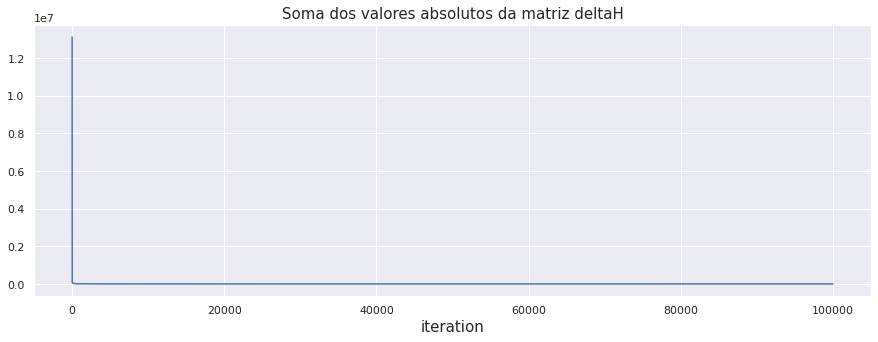

In [70]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.gradient_magnitude
)
plt.title('Soma dos valores absolutos da matriz deltaH', fontsize=15)
plt.xlabel('iteration', fontsize=15)

Text(0.5, 0, 'iteration')

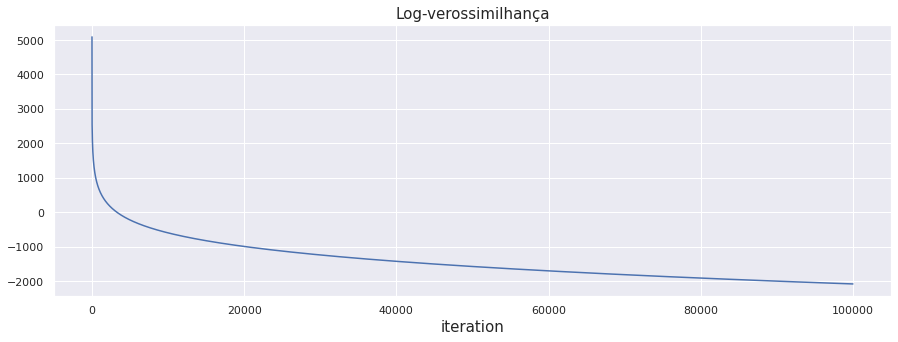

In [71]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.log_likelihood
)
plt.title('Log-verossimilhança', fontsize=15)
plt.xlabel('iteration', fontsize=15)

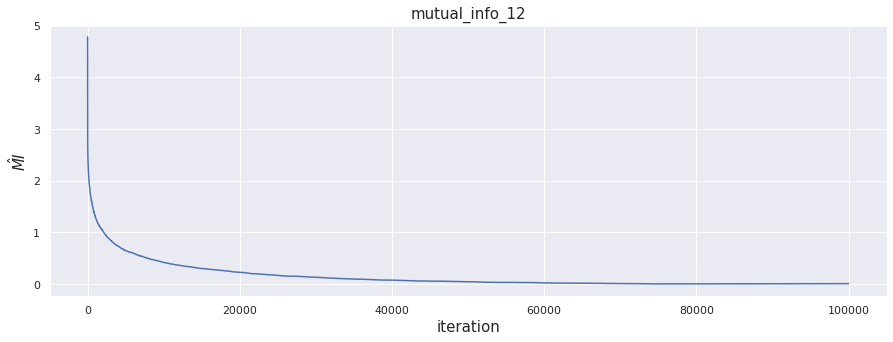

In [72]:
# Plot mutual info
for c in [col for col in logs.columns if 'mutual_info' in col]:
    fig = plt.figure(figsize=((15,5)))
    plt.plot(
        logs.it,
        logs[c]
    )
    plt.title(c, fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

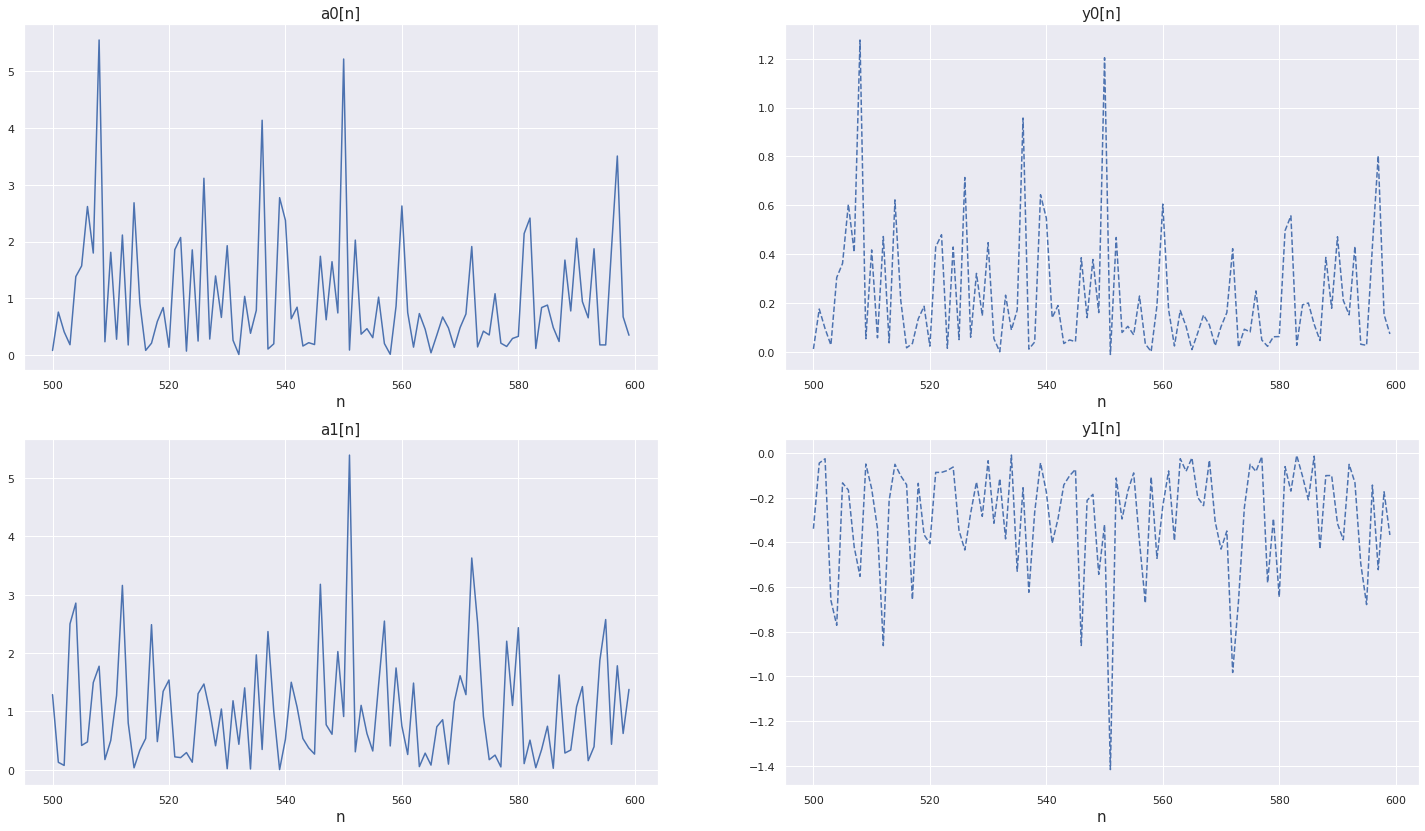

In [73]:
# Plot retrieved sources
y=np.linalg.inv(H_est)@x
START_PLOT=500
END_PLOT=600

fig, axs = plt.subplots(
    nrows=K, ncols=2,
    figsize=(25, 7*K)
)

for k, ax in enumerate(axs[:,0]):
    ax.plot(
        range(START_PLOT,END_PLOT),
        a[k,START_PLOT:END_PLOT],
    )
    ax.set_xlabel(
        'n',
        fontsize=15
    )
    ax.set_title(
        'a{}[n]'.format(k),
        fontsize=15
    )

for k, ax in enumerate(axs[:,1]):
    ax.plot(
        range(START_PLOT,END_PLOT),
        y[k,START_PLOT:END_PLOT],
        linestyle='--'
    )
    ax.set_xlabel(
        'n',
        fontsize=15
    )
    ax.set_title(
        'y{}[n]'.format(k),
        fontsize=15
    )

### 2.2. Identity initialization

In [3]:
# Initialize random H
H_est=np.eye(
    N=K
)

# Iterate to find optimal W
n_it=100000
learning_rate=3E-8
logs = pd.DataFrame()
combinations = [t for t in itertools.combinations(
    range(1,K+1),
    2
)]
for k in tqdm(range(1, n_it+1)):
    y=np.linalg.inv(H_est)@x
    det_H = np.linalg.det(H_est)
    adj_H = np.linalg.inv(H_est)*det_H
    delta_H=np.zeros((K,K))
    for i,j in np.ndindex((K,K)):
        ij_indicator_matrix = np.zeros((K,K))
        ij_indicator_matrix[i,j]=1
        Hinv_derivative = -np.linalg.inv(H_est)*ij_indicator_matrix*np.linalg.inv(H_est)
        csi_derivative = np.sum([
            Lamb[i]*Hinv_derivative[i,j]*np.sum(x[j,:]) for i, j in np.ndindex(K,K)
        ])
        # csi_derivative = 
        delta_H[i,j] = - N*np.sign(det_H)*adj_H[j,i]/np.abs(det_H) - csi_derivative
        

    # Update model of H
    H_est = H_est - learning_rate*delta_H
    
    # Update logs matrix
    logs_update = pd.DataFrame(
        index=[0],
        data={
            'it': [k],
            'gradient_magnitude': [np.sum(np.abs(delta_H))],
            'log_likelihood': [-N*np.log(np.abs(det_H)) + N*np.sum(np.log(Lamb)) - Lamb.reshape((1,K))@np.linalg.inv(H_est)@np.sum(x, axis=1).reshape((K,1))]
        }
    )
    for c in combinations:
        logs_update['mutual_info_{}{}'.format(c[0], c[1])] = MI(
            y.T, y.T[:,c[1]-1]
        )[c[0]-1]
    
    logs = pd.concat(
        [
            logs,
            logs_update
        ],
        axis=0
    )

100%|█████████████████████████████████████████████████████████████████████| 100000/100000 [16:33<00:00, 100.68it/s]


In [4]:
print('-'*100)
print('Original H:\n{}'.format(H))
print('Estimated H:\n{}'.format(H_est))
print('-'*100)

----------------------------------------------------------------------------------------------------
Original H:
[[ 0.5 -0.5]
 [ 0.5  0.5]]
Estimated H:
[[2.65688193 0.        ]
 [0.         0.99414246]]
----------------------------------------------------------------------------------------------------


In [5]:
print('-'*100)
print('Original Hinv:\n{}'.format(np.linalg.inv(H)))
print('Estimated Hinv:\n{}'.format(np.linalg.inv(H_est)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Original Hinv:
[[ 1.  1.]
 [-1.  1.]]
Estimated Hinv:
[[0.37638105 0.        ]
 [0.         1.00589205]]
----------------------------------------------------------------------------------------------------


Text(0.5, 0, 'iteration')

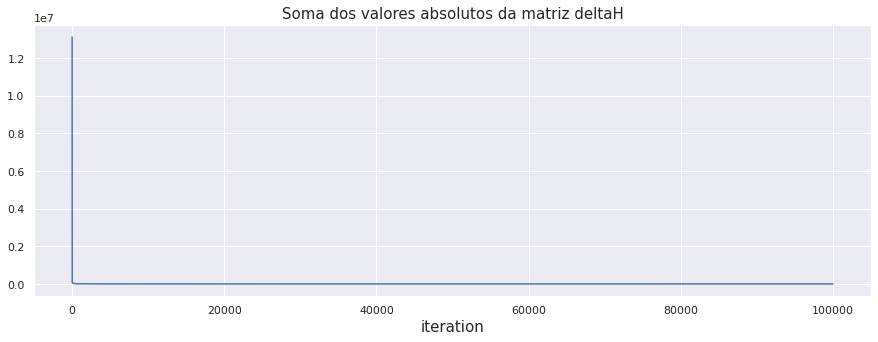

In [70]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.gradient_magnitude
)
plt.title('Soma dos valores absolutos da matriz deltaH', fontsize=15)
plt.xlabel('iteration', fontsize=15)

Text(0.5, 0, 'iteration')

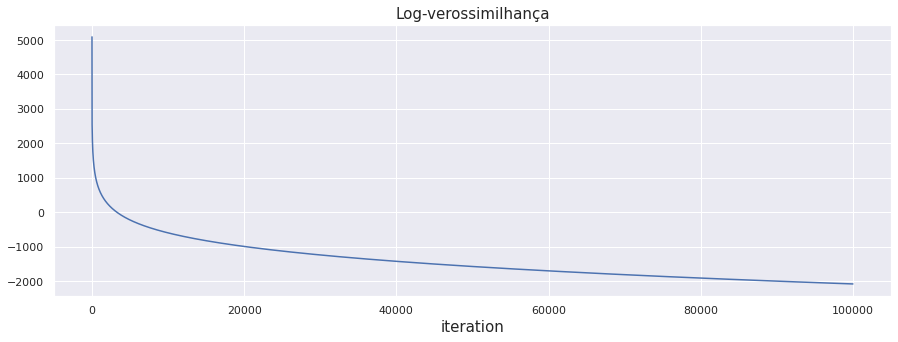

In [71]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.log_likelihood
)
plt.title('Log-verossimilhança', fontsize=15)
plt.xlabel('iteration', fontsize=15)

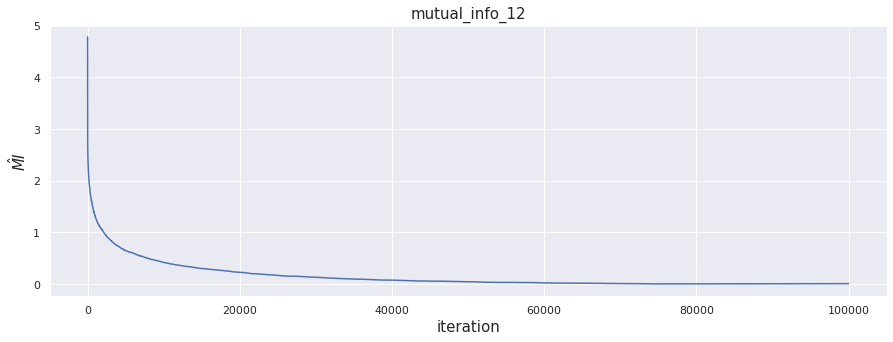

In [72]:
# Plot mutual info
for c in [col for col in logs.columns if 'mutual_info' in col]:
    fig = plt.figure(figsize=((15,5)))
    plt.plot(
        logs.it,
        logs[c]
    )
    plt.title(c, fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

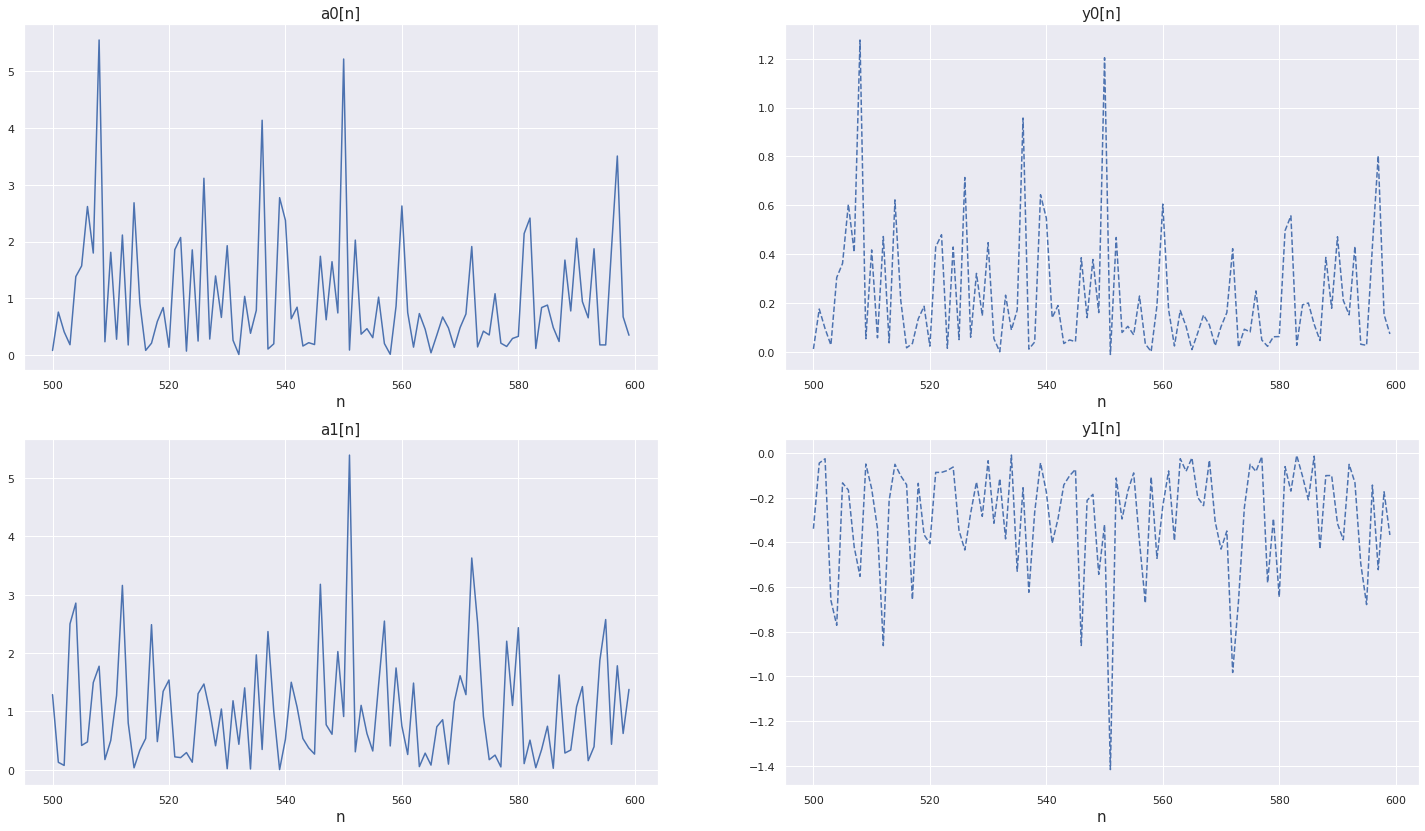

In [73]:
# Plot retrieved sources
y=np.linalg.inv(H_est)@x
START_PLOT=500
END_PLOT=600

fig, axs = plt.subplots(
    nrows=K, ncols=2,
    figsize=(25, 7*K)
)

for k, ax in enumerate(axs[:,0]):
    ax.plot(
        range(START_PLOT,END_PLOT),
        a[k,START_PLOT:END_PLOT],
    )
    ax.set_xlabel(
        'n',
        fontsize=15
    )
    ax.set_title(
        'a{}[n]'.format(k),
        fontsize=15
    )

for k, ax in enumerate(axs[:,1]):
    ax.plot(
        range(START_PLOT,END_PLOT),
        y[k,START_PLOT:END_PLOT],
        linestyle='--'
    )
    ax.set_xlabel(
        'n',
        fontsize=15
    )
    ax.set_title(
        'y{}[n]'.format(k),
        fontsize=15
    )

Text(0.5, 0, 'iteration')

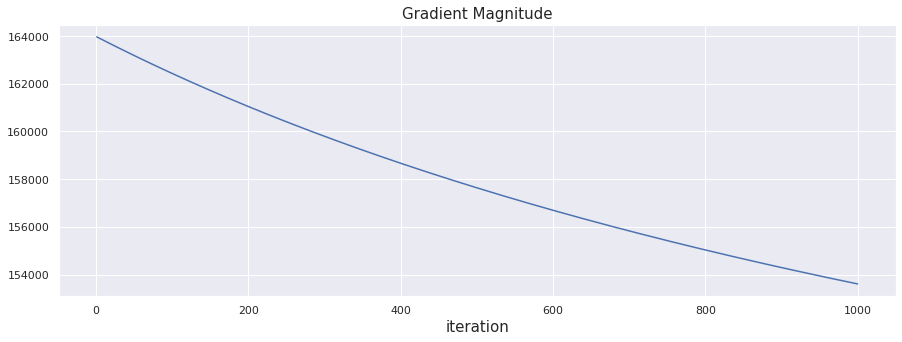

In [95]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.gradient_magnitude
)
plt.title('Gradient Magnitude', fontsize=15)
plt.xlabel('iteration', fontsize=15)

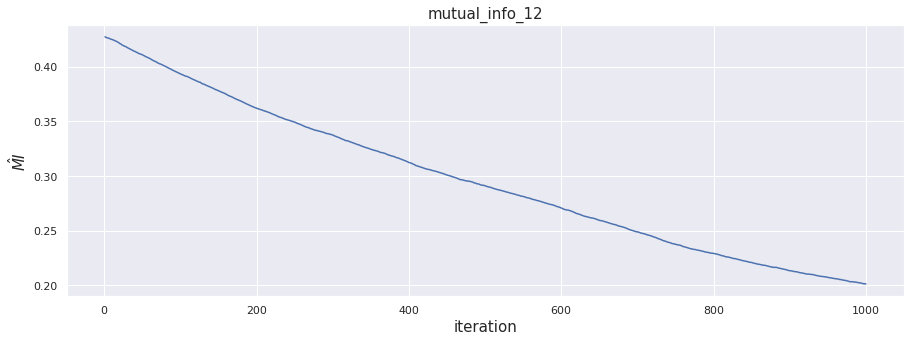

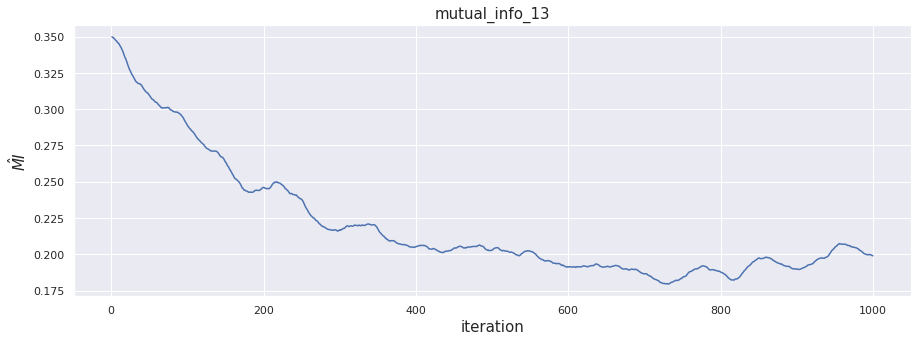

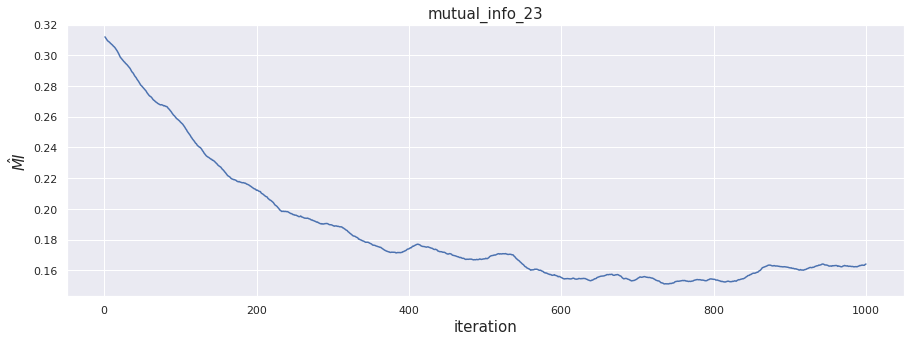

In [96]:
# Plot mutual info
for c in [col for col in logs.columns if 'mutual_info' in col]:
    fig = plt.figure(figsize=((15,5)))
    plt.plot(
        logs.it,
        logs[c]
    )
    plt.title(c, fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

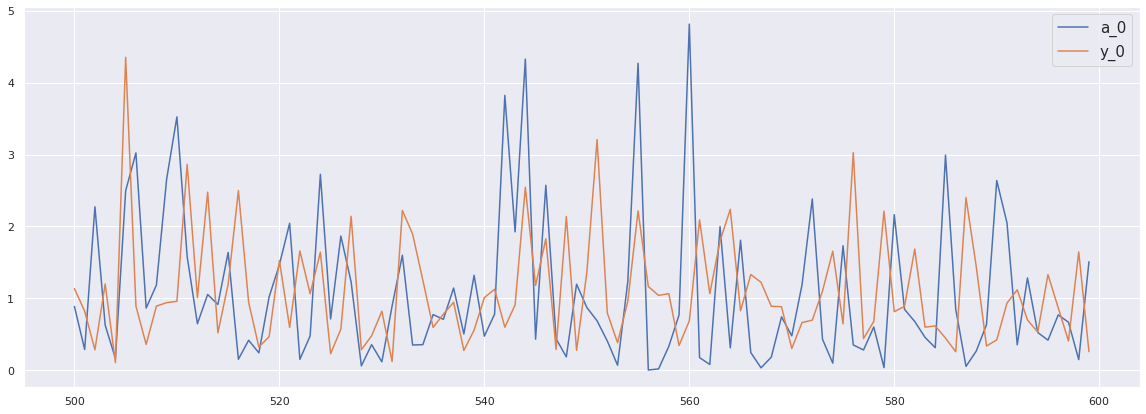

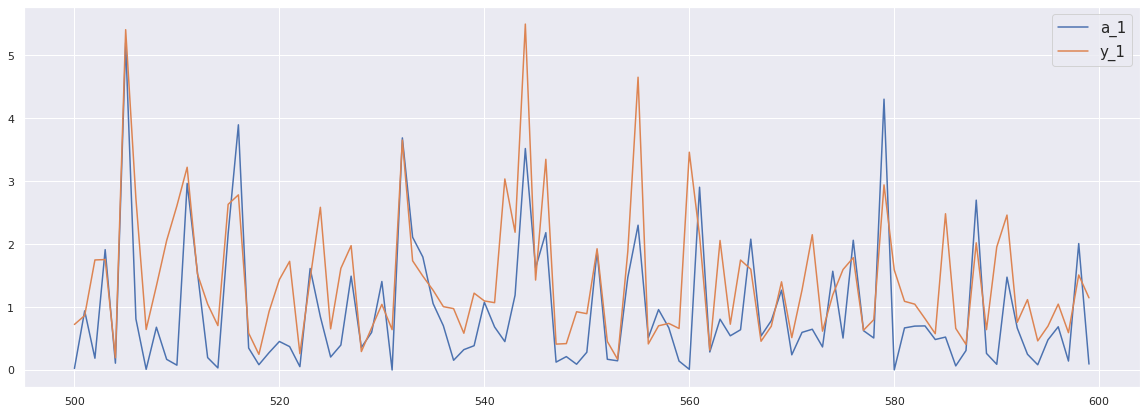

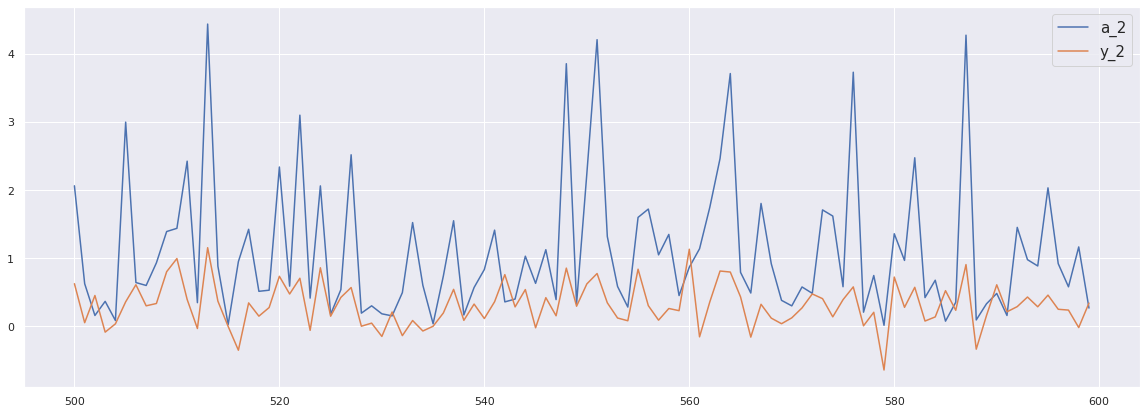

In [97]:
# Plot retrieved sources
y=np.linalg.inv(H_est)@x
START_PLOT=500
END_PLOT=600

for k in range(K):
    fig = plt.figure(figsize=(20,7))
    plt.plot(
        range(START_PLOT,END_PLOT),
        a[k,START_PLOT:END_PLOT],
        label='a_{}'.format(k)
    )
    plt.plot(
        range(START_PLOT,END_PLOT),
        y[k,START_PLOT:END_PLOT],
        label='y_{}'.format(k)
    )
    plt.legend(fontsize=15,loc='upper right')